In [214]:
format long
DM.set_precision(15)

# Nonlinear programming and code-generation in CasADi


  Joris Gillis, joris.gillis@kuleuven.be
  
  
  
 - MECO Research Team, Department Mechanical Engineering, KU Leuven
 - DMMS lab, Flanders Make, Leuven, Belgium
 
Benelux-meeting 2019

<div>
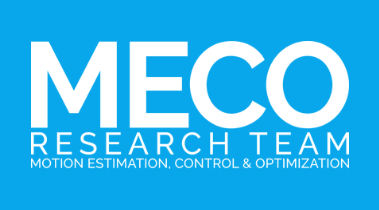

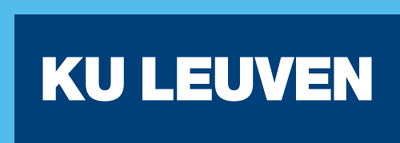
</div>

## Presentation contents

 * Nonlinear MPC in CasADi
 * Highlighted features in upcoming CasADi 3.5


## CasADi?

 * Open-source framework for algorithmic differentiation and nonlinear programming
 * Joel Andersson, Joris Gillis, Greg Horn. Since 2010
 * http://casadi.org
 
 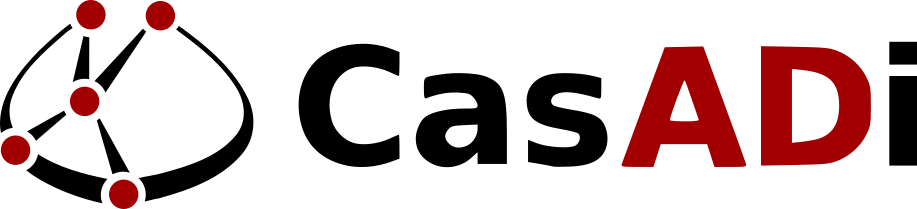

## Ingredient 1: computational graphs

Let's define an ode $\dot{x}=f(x,u)$ with states $x \in \mathbf{R}^2$ and controls $u \in \mathbf{R}$

In [1]:
import casadi.*

x1 = MX.sym('x1'); % States
x2 = MX.sym('x2');
x  = [x1; x2];    
u  = MX.sym('u'); % Controls

% Van der Pol oscillator system  (nonlinear ODE)
ode = [(1-x2^2)*x1 - x2 + u; x1];

f = Function('f',{x,u},{ode},{'x','u'},{'ode'})
f([0.2;0.8],0.1)

f =

f:(x[2],u)->(ode[2]) MXFunction

ans =

[-0.628, 0.2]



## Ingredient 2: time-integration methods

In [2]:
T = 10; % Time horizon
N = 20; % Number of control intervals

% Integrator to discretize the system
intg_options = struct;
intg_options.tf = T/N;
intg_options.simplify = true;
intg_options.number_of_finite_elements = 4;

% DAE problem structure
dae = struct;
dae.x = x;         % What are states?
dae.p = u;         % What is fixed suring the integration horizon?
dae.ode = f(x,u);  % Expression for the right-hand side

intg = integrator('intg','rk',dae,intg_options)

intg =

intg:(x0[2],p,z0[0],rx0[],rp[],rz0[])->(xf[2],qf[0],zf[2x3],rxf[],rqf[],rzf[]) MXFunction



## Ingredient 3: Function objects

In [25]:
intg([0;1],0,[],[],[],[])   % A bit hard to follow what all the arguments are

ans =

[-0.494016760265394, 0.876098253739269]



In [26]:
intg('x0',[0;1],'p',0)  % Easier to identify inputs, but bloated API

ans =

  scalar structure containing the fields:

    qf =

    []

    rqf =

    []

    rxf =

    []

    rzf =

    []

    xf =

    [-0.494016760265394, 0.876098253739269]

    zf =

    
[[-0.43227517748097, -0.432493034891329, -0.493872431809776], 
 [0.906960332296844, 0.903131542635244, 0.876087111866389]]




In [5]:
res = intg('x0',x,'p',u); % Evaluate with symbols
x_next = res.xf

x_next =

@1=0x0, intg(vertcat(x1, x2), u, 0x1, @1, @1, @1){0}



In [6]:
% Simplify API to (x,u)->(x_next)
F = Function('F',{x,u},{x_next},{'x','u'},{'x_next'})
F([0;1],0)
F([0.1;0.9],0.1)

F =

F:(x[2],u)->(x_next[2]) MXFunction

ans =

[-0.494017, 0.876098]

ans =

[-0.307745, 0.849043]



## Ingredient 4: concepts from functional programming

In [7]:
F
sim = F.mapaccum(N)

F =

F:(x[2],u)->(x_next[2]) MXFunction

sim =

mapaccum_F:(x[2],u[1x20])->(x_next[2x20]) MXFunction



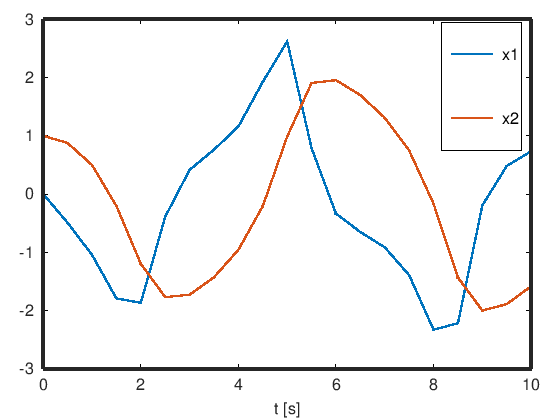

In [8]:
x0 = [0;1];
res = sim(x0,zeros(1,N));

figure
tgrid = linspace(0,T,N+1);
plot(tgrid,full([x0 res]));
legend('x1','x2');
xlabel('t [s]');
nice_fig

## Ingredient 5: symbolic differentation

ans =

   20   20



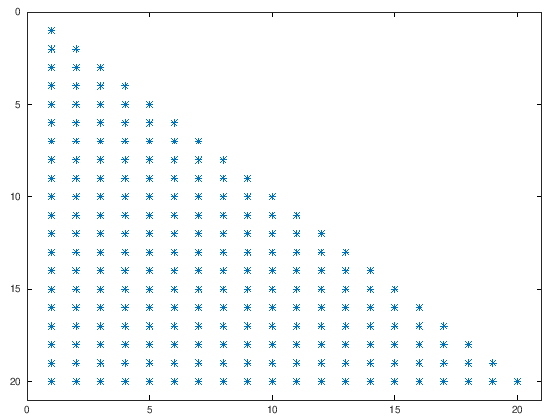

In [9]:
U = MX.sym('U',1,N);

X1 = sim(x0,U)(1,:); % Simulate using concrete x0 and symbolic input series

J = jacobian(X1,U);  % Jacobian of first states wrt to input series

size(J)

spy(J)

Jf =

F:(i0[1x20])->(o0[20x20,210nz]) MXFunction



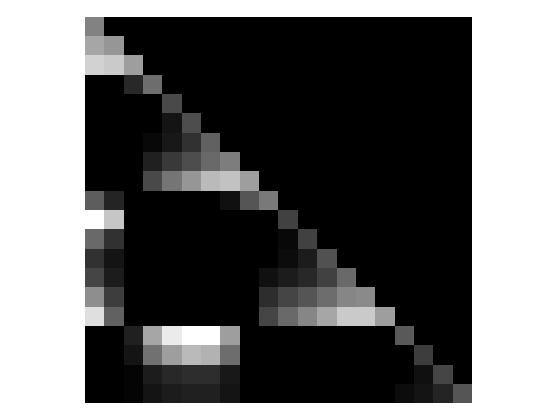

In [10]:
Jf = Function('F',{U},{J})
imshow(full(Jf(0)))

## Optimal control problem using multiple-shooting

$M(p) := $
\begin{equation}
  \begin{array}{cl}
    \underset{x_1,\ldots x_{N+1},u_1,\ldots u_N}{\textrm{minimize}} & \sum_{k=1}^{N+1} x_k^T x_k + \sum_{k=1}^{N} u_k^T u_k \\
    \textrm{subject to} &  x_{k+1} = F(x_k,u_k) \\
     & -1 \le u \le 1 \\
     & x_1 = p
  \end{array}
\end{equation}

In [11]:
opti = casadi.Opti();

x = opti.variable(2,N+1); % Decision variables for state trajetcory
u = opti.variable(1,N);
p = opti.parameter(2,1);  % Parameter (not optimized over)

opti.minimize(sumsqr(x)+sumsqr(u));

for k=1:N
  opti.subject_to(x(:,k+1)==F(x(:,k),u(:,k)));
end
opti.subject_to(-1<=u<=1);
opti.subject_to(x(:,1)==p);

opti

opti =

Opti {
  instance #0
  #variables: 2 (nx = 62)
  #parameters: 1 (np = 2)
  #constraints: 22 (ng = 62)
  CasADi solver needs updating.
}



In [12]:
% Choose a concerete solver
opti.solver('sqpmethod',struct('qpsol','qrqp'));

% And choose a concrete value for p
opti.set_value(p,[0;1]);
sol = opti.solve();

-------------------------------------------
This is casadi::QRQP
Number of variables:                              62
Number of constraints:                            62
Number of nonzeros in H:                         182
Number of nonzeros in A:                         182
Number of nonzeros in KKT:                       608
Number of nonzeros in QR(V):                     443
Number of nonzeros in QR(R):                     784
-------------------------------------------
This is casadi::Sqpmethod.
Using exact Hessian
Number of variables:                              62
Number of constraints:                            62
Number of nonzeros in constraint Jacobian:       182
Number of nonzeros in Lagrangian Hessian:        182

iter      objective    inf_pr    inf_du     ||d||  lg(rg) ls
   0   0.000000e+00  1.00e+00  0.00e+00  0.00e+00       -  0
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0         1   123  2.4e-308     

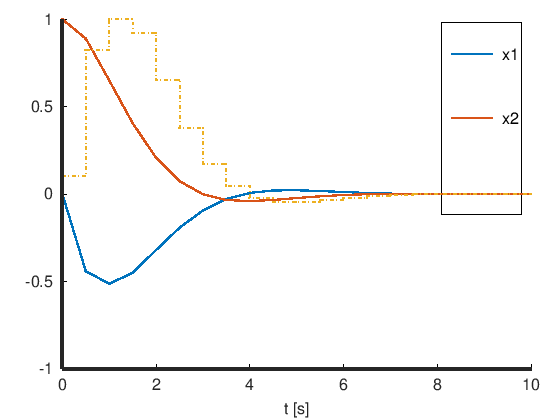

In [13]:
figure
hold on
plot(tgrid,sol.value(x));
stairs(tgrid, [sol.value(u) nan], '-.');
xlabel('t [s]');
legend('x1','x2','u');
nice_fig

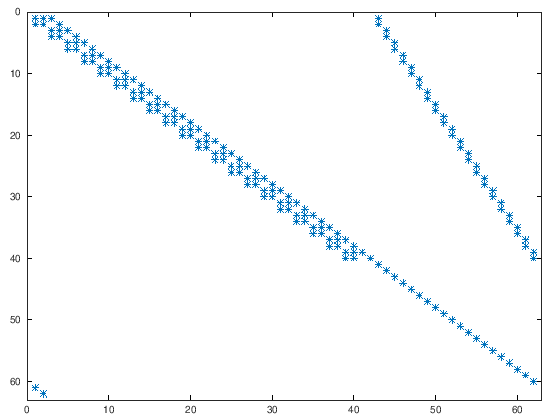

In [14]:
spy(jacobian(opti.g,opti.x));

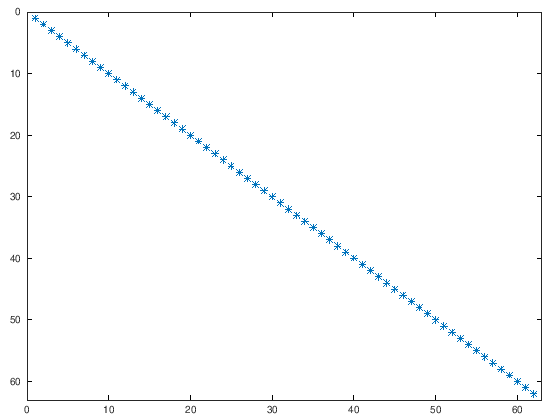

In [15]:
spy(hessian(opti.f,opti.x));

In [16]:
% Make the solver silent
opts = struct;
opts.qpsol = 'qrqp';
opts.print_header = false;
opts.print_iteration = false;
opts.print_time = false;
opts.qpsol_options.print_iter = false;
opts.qpsol_options.print_header = false;
opts.qpsol_options.print_info = false;
opti.solver('sqpmethod',opts);

## Feature highlight 1: from Opti (NLP modeling) to CasADi Functions

In [18]:
M = opti.to_function('M',{p},{u(:,1)},{'p'},{'u_opt'})

M =

M:(p[2])->(u_opt) MXFunction



In [19]:
% MPC loop
X_log = [];
U_log = [];

x = x0;
for i=1:4*N
  u = full(M(x));

  U_log(:,i) = u;
  X_log(:,i) = x;

  % simulate system
  x = full(F(x,u)) + [0;rand*0.02];
end

MESSAGE(sqpmethod): Convergence achieved after 4 iterations
MESSAGE(sqpmethod): Convergence achieved after 4 iterations
MESSAGE(sqpmethod): Convergence achieved after 4 iterations
MESSAGE(sqpmethod): Convergence achieved after 3 iterations
MESSAGE(sqpmethod): Convergence achieved after 3 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 1 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved

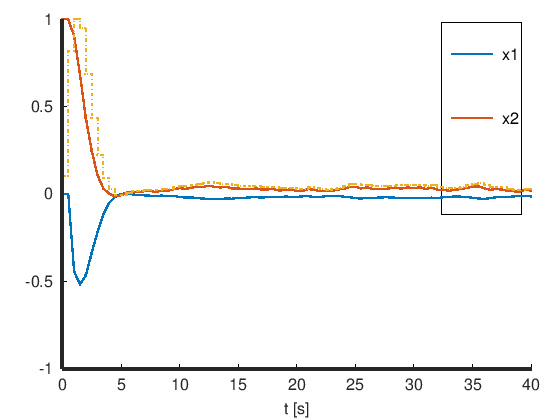

In [20]:
figure
hold on
tgrid_mpc = linspace(0,4*T,4*N+1);
plot(tgrid_mpc,[x0 X_log]);
stairs(tgrid_mpc, [U_log nan], '-.')
xlabel('t [s]');
legend('x1','x2','u');
nice_fig

## Feature highlight 2: loading and saving Function objects

In [21]:
M.save('M.casadi');
M2 = Function.load('M.casadi');

DM.set_precision(15)

M(x0)
M2(x0)

MESSAGE(sqpmethod): Convergence achieved after 4 iterations
ans =

0.101897523198779

MESSAGE(sqpmethod): Convergence achieved after 4 iterations
ans =

0.101897523198779



## Feature highlight 3: Code-generation with solver embedded

In [23]:
M.generate('codegen_demo',struct('mex',true));
disp('Compiling...')
mex codegen_demo.c -DMATLAB_MEX_FILE
disp('done')

Compiling...
done


In [24]:
format long
codegen_demo('M',x0)

ans =  0.101897523198779


# Nonlinear programming and code-generation in CasADi


  Joris Gillis, joris.gillis@kuleuven.be
  
  
  
 - MECO Research Team, Department Mechanical Engineering, KU Leuven
 - DMMS lab, Flanders Make, Leuven, Belgium
 

Benelux-meeting 2019